In [1]:
import sys
if False: # On colab
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    root = "/content/drive/My Drive/Colab Notebooks/burgers/"
    sys.path.append("/content/drive/My Drive/Colab Notebooks/burgers/")
else: # Local
    root = './'
import numpy as np
import torch
from matplotlib import pylab as plt
if torch.cuda.device_count()>0:
    device = torch.device('cuda:'+str(torch.cuda.device_count()-1))
    print("Connected to a GPU")
else:
    print("Using the CPU")
    device = torch.device('cpu')

Connected to a GPU


In [2]:
import importlib
import util
importlib.reload(util)
from util import *

In [3]:
loss = torch.nn.MSELoss()
def train_it(dataset, model,
             OPTIM=torch.optim.Adam, learning_rate = 1e-1, batch_size=20,
             Npast=1, Nfuture=1):
    optimizer = OPTIM(model.parameters(), lr=learning_rate)
    Nepoch = 1000
    Ntotal = dataset.shape[0]*(dataset.shape[1]-(Npast+1)-Nfuture)
    Nbatch = batch_size #Ntotal//10
    Niter = Nepoch * Ntotal//Nbatch
    Nprint = (Niter)//10
    Nsave = 100
    losses = np.zeros((Niter//Nsave,2))
    
    for e in range(Niter):
        xx,yy = get_batch(Nbatch, dataset, Nfuture=Nfuture)
        # We iterate multiple times:
        y_pred = model(xx)+xx
        L = loss(y_pred,yy[:,(0,),:])
        for i in range(1,Nfuture):
            h = y_pred
            y_pred = model(h)+h
            L += loss(y_pred, yy[:,(i,),:])
        # Optimize:
        optimizer.zero_grad()
        L.backward()
        optimizer.step()
        # Make stats:
        if e%Nprint == Nprint-1:
            print(e,L.item())
        if e%Nsave == Nsave-1:
            xxt,yyt = test_batch(dataset)
            yt_pred = model(xxt)+xxt
            test_err = loss(yyt,yt_pred)
            losses[e//Nsave,0] = L.item()
            losses[e//Nsave,1] = test_err.item()
    return losses

In [39]:
dataname = "burgers"
data = np.load(root+f"data/{dataname}.npz")
dataset = torch.tensor(data['U'],dtype=torch.float32,device=device)
Ntraj,Nt,Nx = dataset.shape

In [ ]:
Ntraj,Nt,Nx

In [6]:
stash = {}

In [12]:
stash_save = stash.copy()

In [ ]:
for act in ["ReLU","CELU",]:#"LeakyReLU","ReLU",Tanh
    for depth in [3,]:
        for channels in [5,10]:
            for nstep in [2,3,4,]:
                key = (act,depth,channels, nstep)
                try:
                    entry = stash[key]
                    print("Resuming training of ",key)
                except KeyError:
                    entry = { 'model'   : LeakyDeepStencil(Nx,3,channels,depth,act).to(device),
                            'results' : np.empty((0,2)) }
                    print("Training new ",key)
                model = entry['model']
                results = entry['results']
                tr_res = train_it(dataset,model,learning_rate=1.0e-3, batch_size=50, Nfuture=nstep)
                results = np.append(results, tr_res, axis=0)
                stash[key] = {'model':model,'results':results}
with open(root+f"/models_multi_{dataname}.pkl","wb") as f:
    torch.save(stash,f)

Resuming training of  ('ReLU', 3, 5, 2)
3839 0.0014857914065942168
7679 0.0016914212610572577
11519 0.0032863924279809
15359 0.000589972420129925
19199 0.0013890699483454227
23039 0.0016572958556935191
26879 0.0025388444773852825
30719 0.0010047932155430317
34559 0.0021931063383817673
38399 0.0026219626888632774
Resuming training of  ('ReLU', 3, 5, 3)
3799 0.003613018896430731
7599 0.002857482060790062
11399 0.001459966879338026
15199 0.004314323887228966
18999 0.0030206674709916115
22799 0.005436786450445652
26599 0.0028777061961591244
30399 0.0021012055221945047
34199 0.0025637978687882423
37999 0.0027768053114414215
Resuming training of  ('ReLU', 3, 5, 4)
3759 0.0020726846996694803
7519 0.004450084175914526
11279 0.005184839479625225
15039 0.008141887374222279
18799 0.005295187700539827
22559 0.006782715208828449
26319 0.004822798538953066
30079 0.007804805412888527
33839 0.00437950761988759
37599 0.0041895415633916855
Resuming training of  ('ReLU', 3, 10, 2)
3839 0.0009802543791010

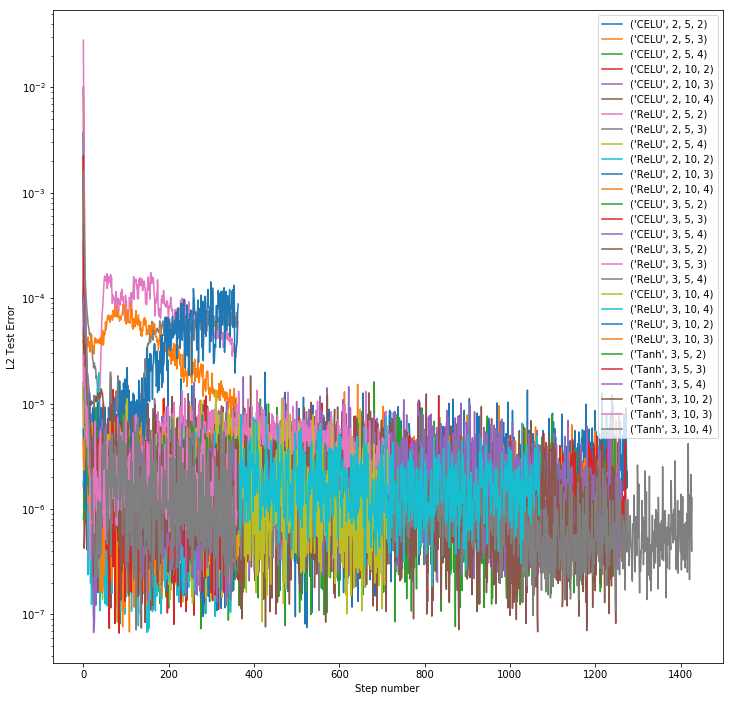

In [37]:
plt.figure(figsize=(12,12))
alpha_channel=1
for N,S in stash.items():
    #plt.semilogy(S['results'][:,1],label=f"{N}, L2")
    plt.semilogy(S['results'][:,1],label=N,alpha=alpha_channel)
    #alpha_channel = 0.25
    #label = None
plt.legend()
plt.xlabel('Step number')
plt.ylabel('L2 Test Error')
plt.savefig(root+'/paper/burgers_multistep_loss.png',dpi=300)
plt.show()

Trajectory  0


ValueError: num must be 1 <= num <= 18, not 19

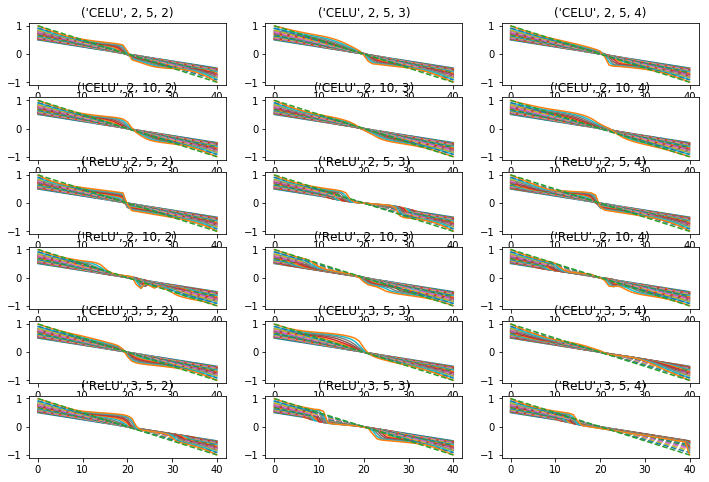

In [36]:
for traj in range(Ntraj): #range(Ntraj-Ntraj_val,Ntraj):
    print("Trajectory ",traj)
    plt.figure(figsize=(12,8))
    err = {}
    for i,(N,S) in enumerate(stash.items()):
        plt.subplot(6,6,i+1)
        err[N] = do_a_path(S['model'],dataset,traj,0)
        plt.title(N)
    plt.tight_layout()
    plt.show()
    for N,e in err.items():
        plt.plot(e,label=N)
    plt.legend()
    plt.ylabel("Error")
    plt.xlabel("Time Step")
    plt.show()

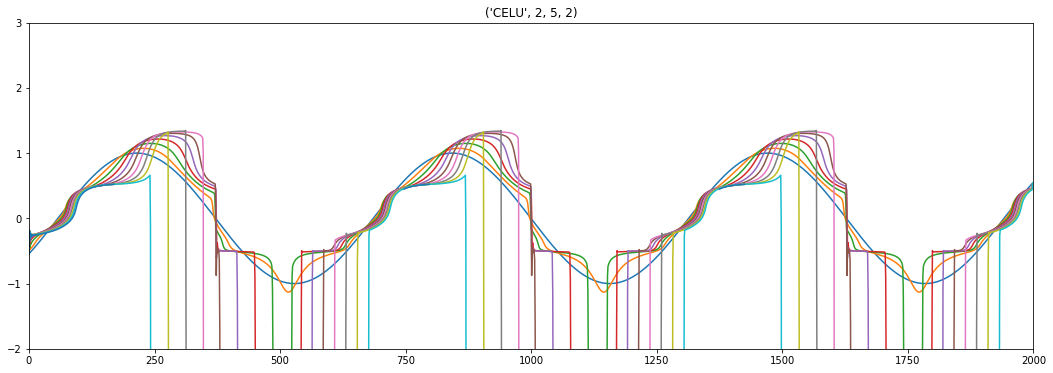

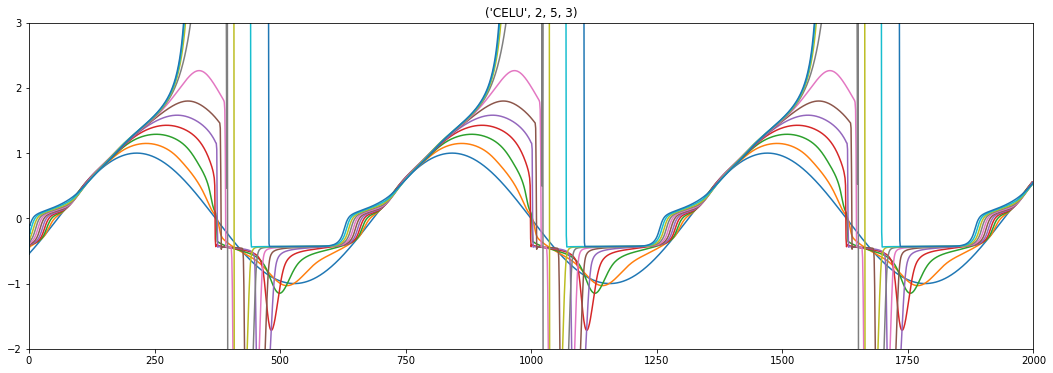

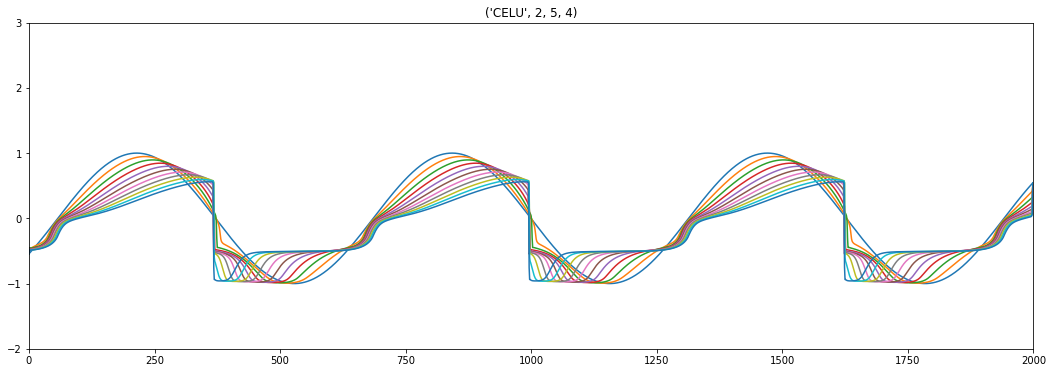

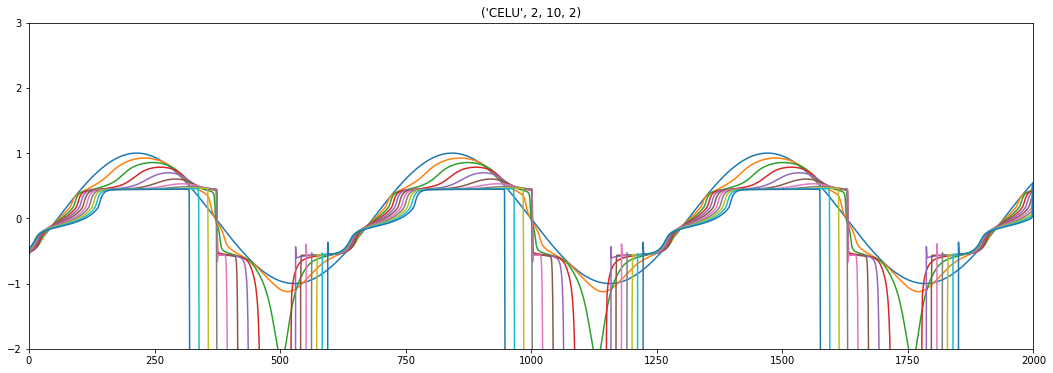

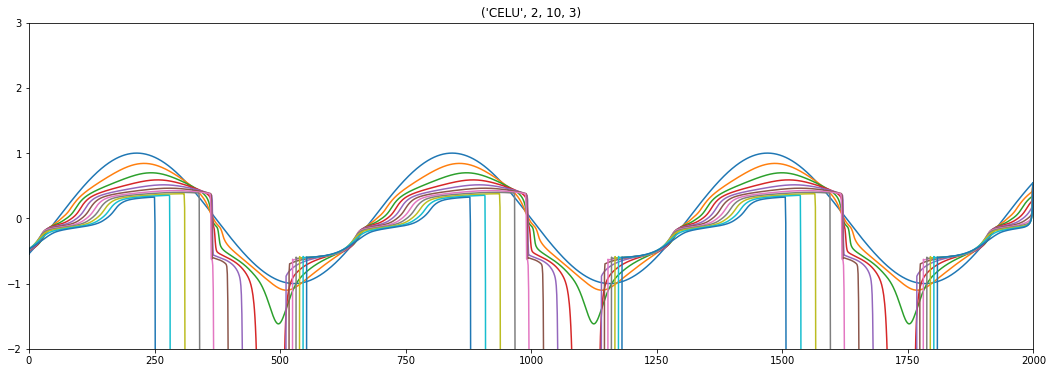

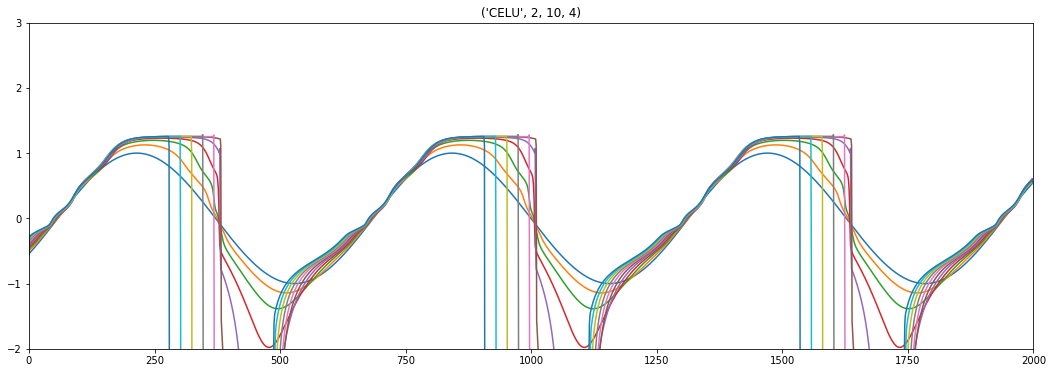

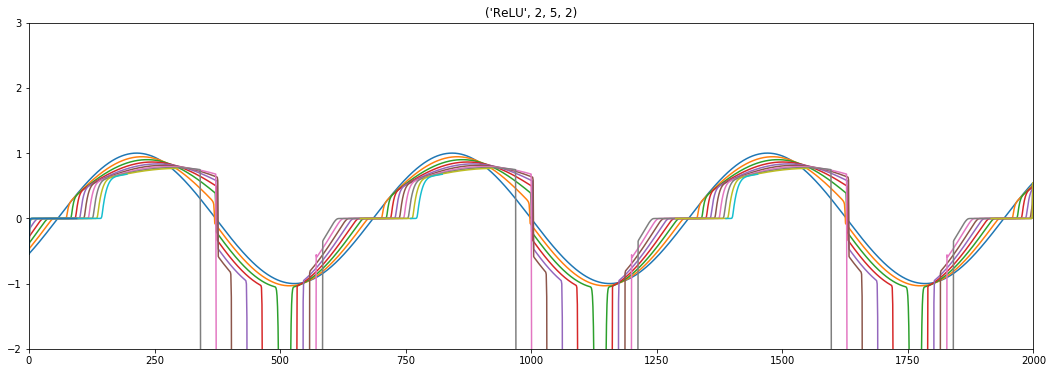

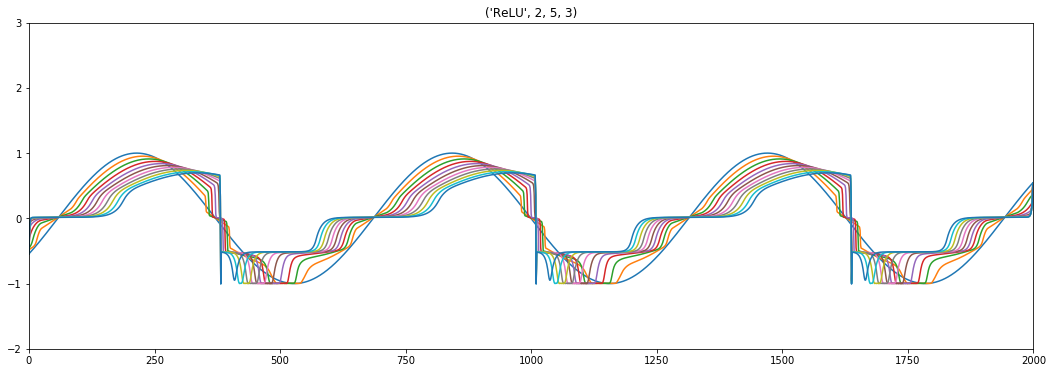

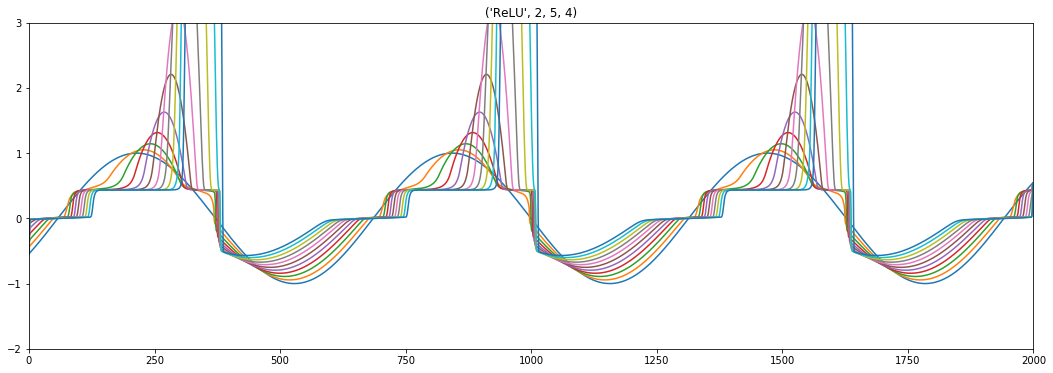

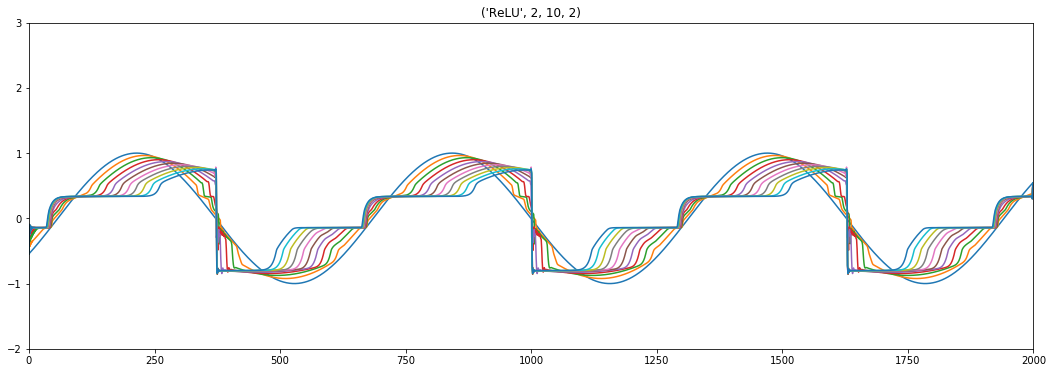

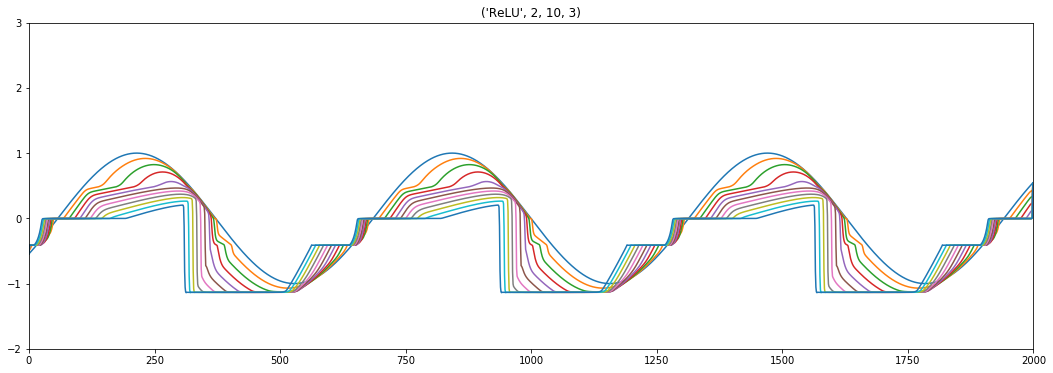

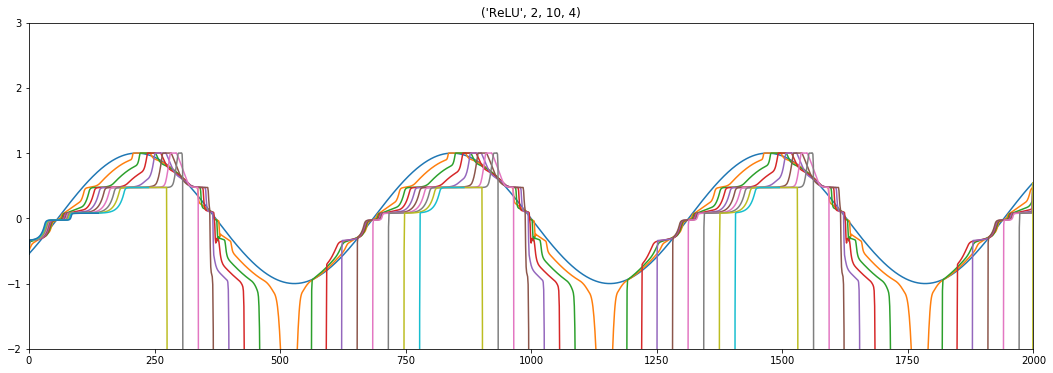

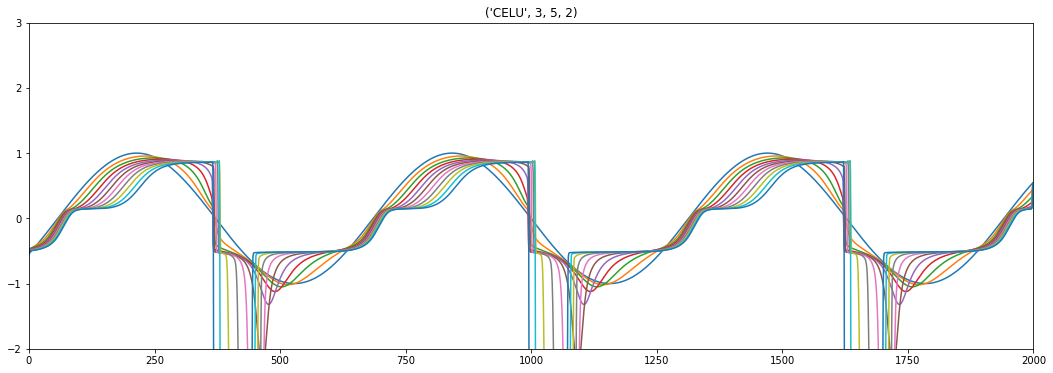

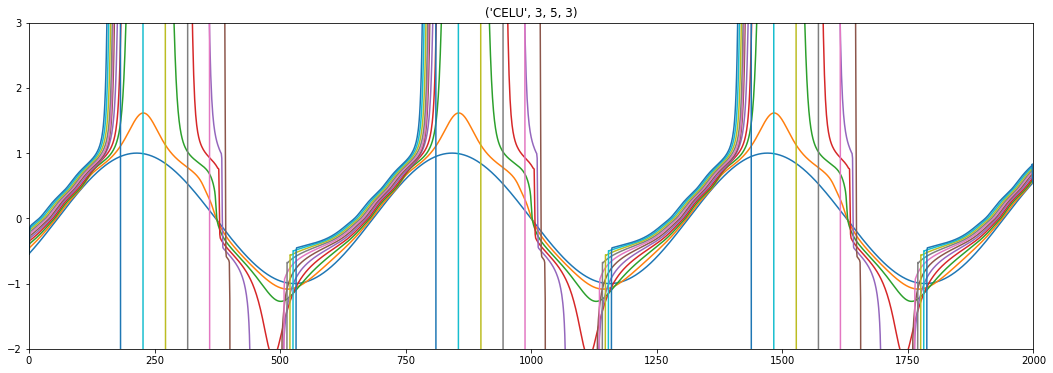

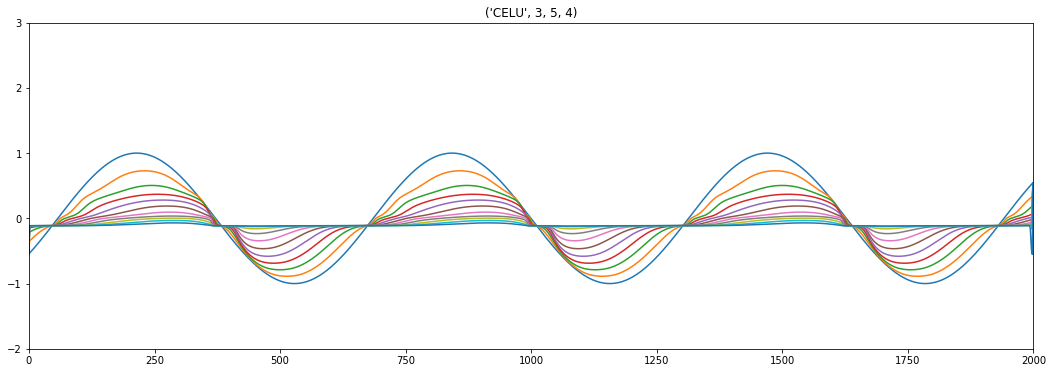

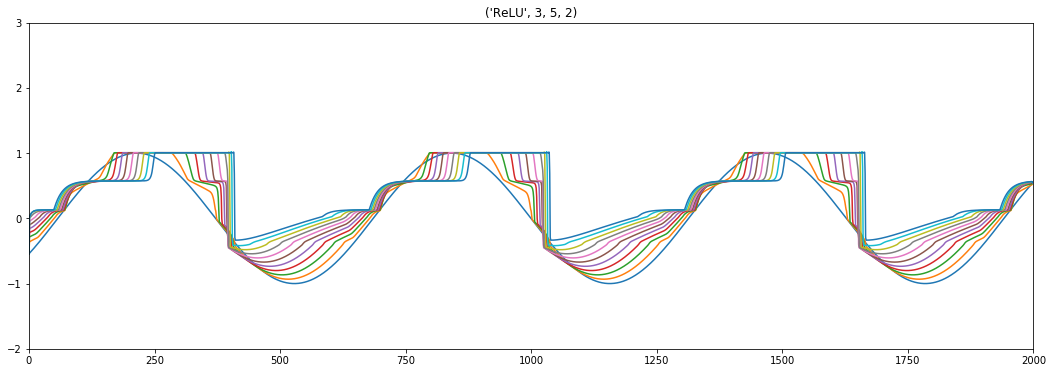

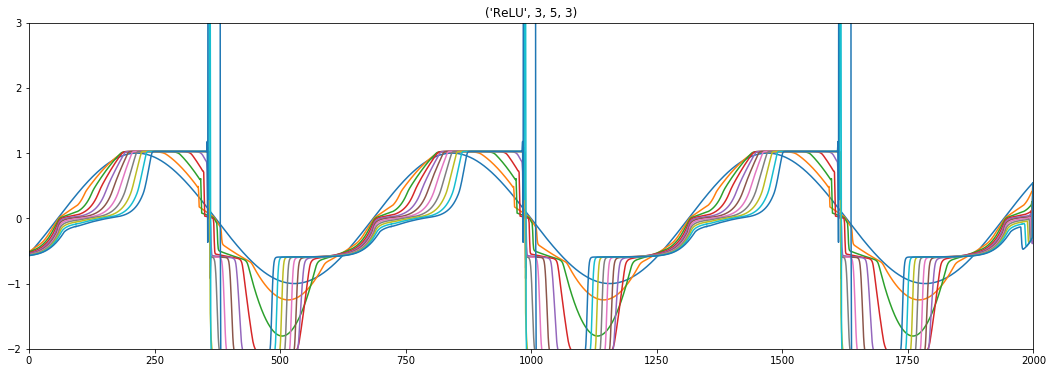

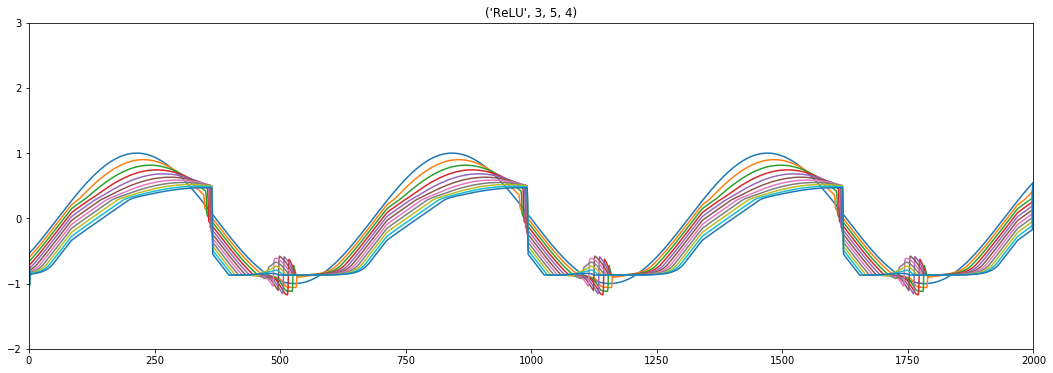

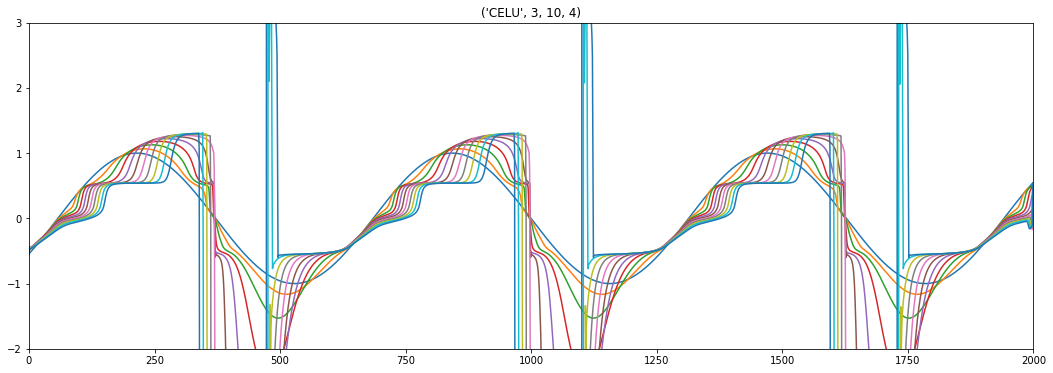

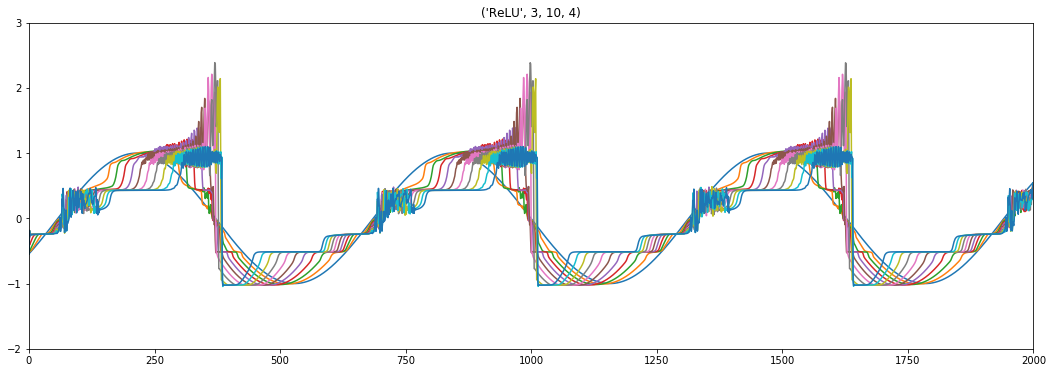

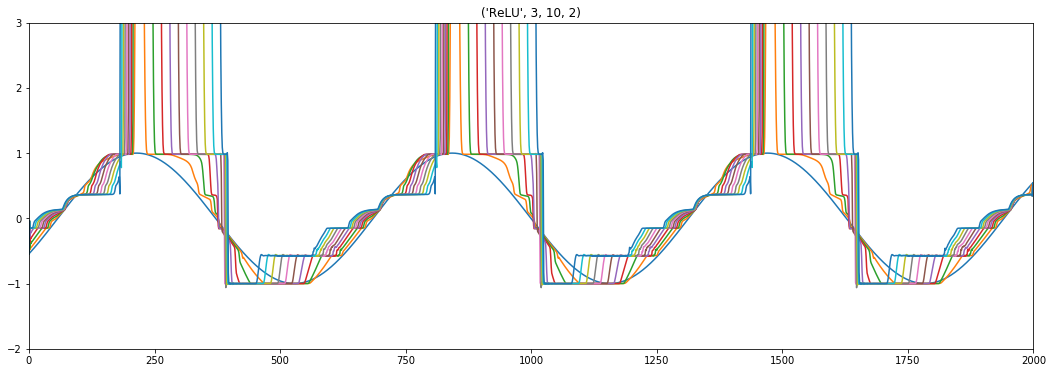

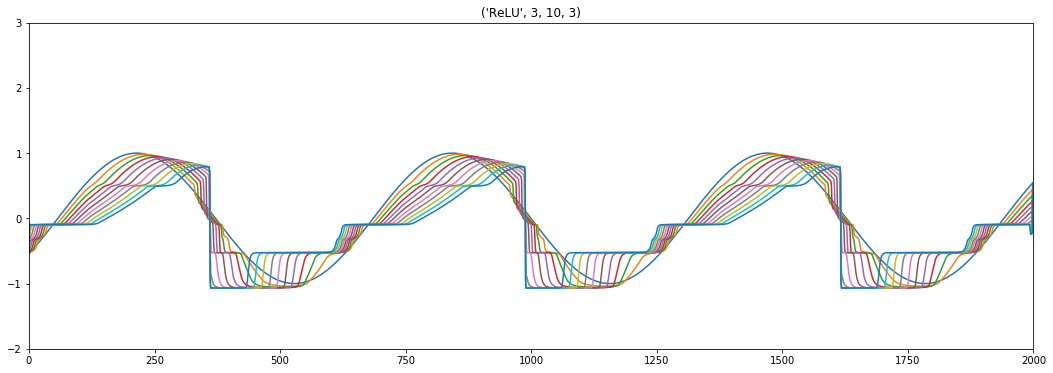

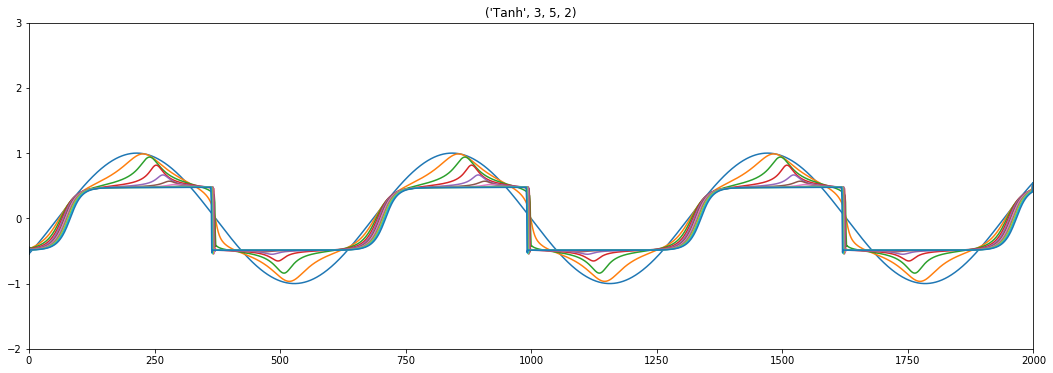

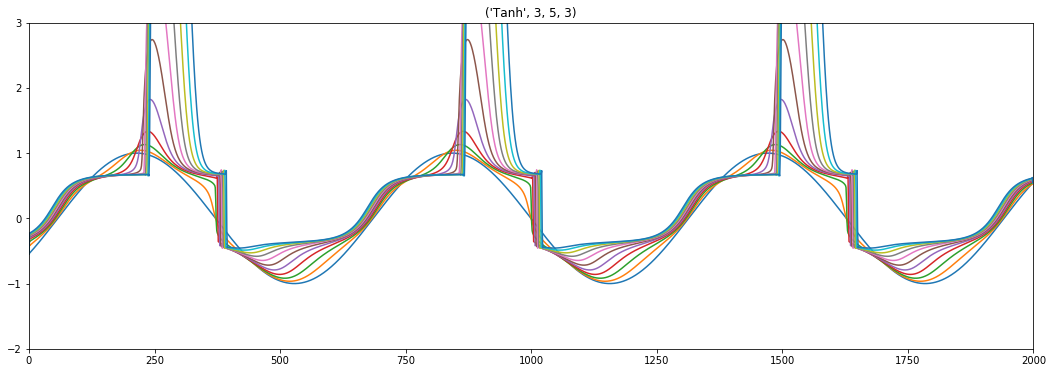

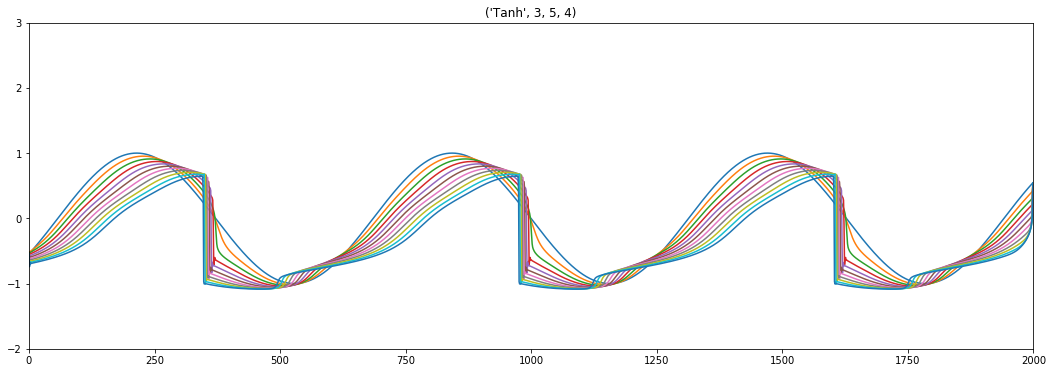

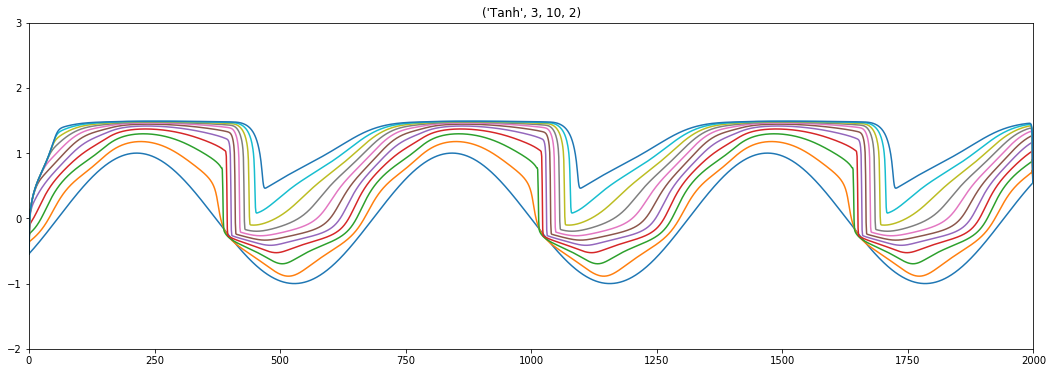

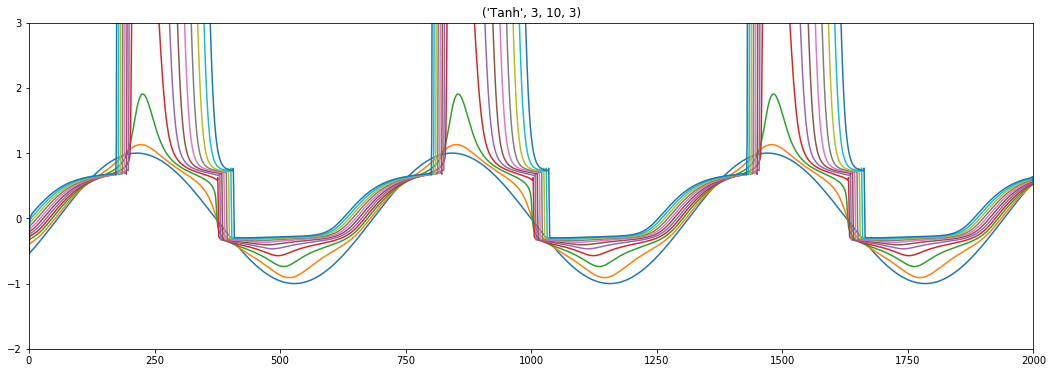

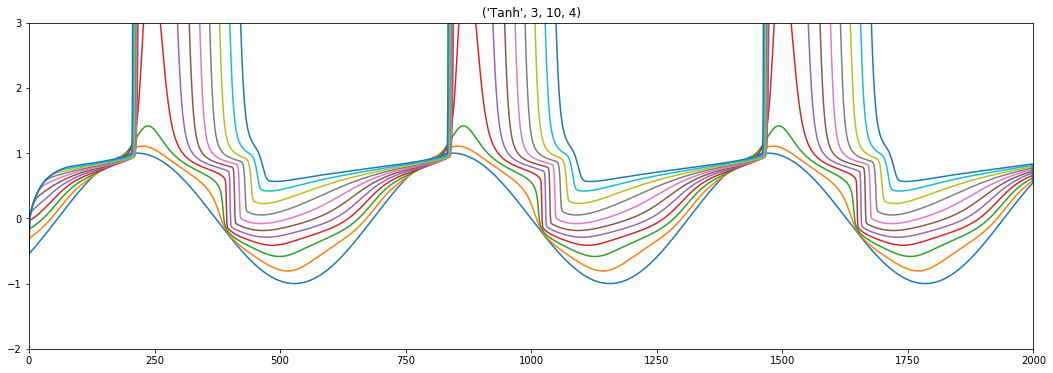

In [38]:
xs = np.linspace(-10,10,2000)
u0 = -np.sin(xs)
for i,(N,S) in enumerate(stash.items()):
    plt.figure(figsize=(18,6))
    plt.ylim((-2,3))
    plt.xlim((0,2000))
    do_an_unknown_path(S['model'], torch.tensor(u0,dtype=torch.float32).to(device), 1000)
    plt.title(N)
    plt.show()

In [33]:
dataset.shape

torch.Size([19, 100, 41])

# Getting rid of the front bias

In [54]:
for act in ["CELU",]:#"LeakyReLU","ReLU",Tanh
    for depth in [2,]:
        for channels in [5,10]:
            for nstep in [3,]:
                key = (act,depth,channels, nstep, False)
                try:
                    entry = stash[key]
                    print("Resuming training of ",key)
                except KeyError:
                    entry = { 'model':LeakyDeepStencil(Nx,3,channels,depth,act,front_bias=False).to(device),
                            'results' : np.empty((0,2)) }
                    print("Training new ",key)
                model = entry['model']
                results = entry['results']
                tr_res = train_it(dataset,model,learning_rate=1.0e-3, batch_size=20, Nfuture=nstep)
                results = np.append(results, tr_res, axis=0)
                stash[key] = {'model':model,'results':results}
with open(root+f"/models_multi_{dataname}.pkl","wb") as f:
    torch.save(stash,f)

Training new  ('CELU', 2, 5, 3, False)
7124 0.003427641000598669
14249 0.011351998895406723
21374 0.006846034433692694
28499 0.00716386316344142
35624 0.004296071827411652
42749 0.02423357032239437
49874 0.024366475641727448
56999 0.005440438166260719
64124 0.003277832642197609
71249 0.01642116717994213
Training new  ('CELU', 2, 10, 3, False)
7124 0.02276470884680748
14249 0.005198967643082142
21374 0.015185883268713951
28499 0.002449601888656616
35624 0.001692942576482892
42749 0.002498018555343151
49874 0.015333368442952633
56999 0.01923774927854538
64124 0.022287258878350258
71249 0.040960293263196945


PicklingError: Can't pickle <class 'util.LeakyDeepStencil'>: it's not the same object as util.LeakyDeepStencil